In [ ]:
! git clone https://github.com/kevinddchen/Keras-FCN.git

Cloning into 'Keras-FCN'...
remote: Enumerating objects: 1546, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 1546 (delta 76), reused 171 (delta 64), pack-reused 1360
Receiving objects: 100% (1546/1546), 62.80 MiB | 17.15 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
%cd Keras-FCN/

/content/Keras-FCN


In [ ]:
import numpy as np
import tensorflow as tf

import utils

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [ ]:
## Paths ======================================
IMAGES_PNG = 'data/images_png/'
LABELS_PNG = 'data/labels_png/'

TRAIN_PNG = 'data/train_png.txt'

TRAIN = 'data/train.tfrecords'
VAL = 'data/val.tfrecords'
## ============================================

In [ ]:
with tf.io.TFRecordWriter(TRAIN) as writer:
    ## write .mat files
    # with open(TRAIN_MAT) as file:
    #     filenames = [s.rstrip('\n') for s in file.readlines()]
    # for name in filenames:
    #     image = utils.get_image(IMAGES_MAT+name+'.jpg')
    #     label = utils.get_label_mat(LABELS_MAT+name+'.mat')
    #     writer.write(utils.get_example(image, label).SerializeToString())
    ## write .png files
    with open(TRAIN_PNG) as file:
        filenames = [s.rstrip('\n') for s in file.readlines()]
    for name in filenames:
        image = utils.get_image(IMAGES_PNG+name+'.jpg')
        label = utils.get_label_png(LABELS_PNG+name+'.png')
        writer.write(utils.get_example(image, label).SerializeToString())

In [ ]:
## only run if using google Colab ##
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/Keras-FCN')
####################################
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle

import utils, augment, models

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
## read data from tfrecords files
def map_func(example):
    image, label = utils.parse_example(example)
    return augment.resize_with_pad(image, label) # no dataset augmentation

train_dataset = tf.data.TFRecordDataset('data/train.tfrecords').map(map_func)
val_dataset = tf.data.TFRecordDataset('data/val.tfrecords').map(map_func)

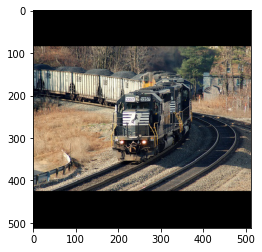

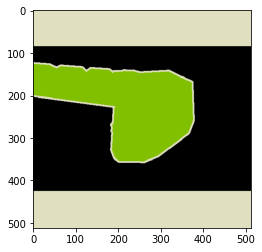

In [ ]:
## check data
for X, y in train_dataset.shuffle(20).take(1):
    plt.figure()
    plt.imshow(X)
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(y))
    plt.show()

In [ ]:
base_model = models.vgg16(l2=1e-6, dropout=0.2)

In [ ]:
## Load ImageNet weights
## https://keras.io/api/applications/
vgg16 = keras.applications.vgg16.VGG16(weights='imagenet')
weight_list = vgg16.get_weights()
weight_list[26] = weight_list[26].reshape(7, 7, 512, 4096)
weight_list[28] = weight_list[28].reshape(1, 1, 4096, 4096)
weight_list[30] = weight_list[30].reshape(1, 1, 4096, 1000)
base_model.set_weights(weight_list)
del weight_list

553467096/553467096 [==============================] - 24s 0us/step


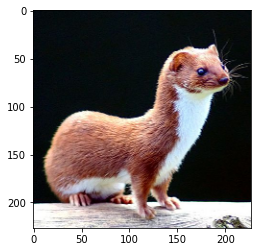

Top three guesses with probabilities:
1/1 [==============================] - 6s 6s/step
weasel (p=0.791)
mink (p=0.103)
polecat, fitch, foulmart, foumart, Mustela putorius (p=0.103)


In [ ]:
from class_names.imagenet import class_names

img = utils.get_image('assets/laska.png')
plt.figure()
plt.imshow(img)
plt.show()

print('Top three guesses with probabilities:')
probs = base_model.predict(img[None])[0, 3, 3] # pick the central prediction from 7 x 7 square
pred = np.argsort(probs)[::-1]
for i in range(3):
    c = pred[i]
    print("{0:s} (p={1:.3f})".format(class_names[c], probs[c]))

In [ ]:
fcn32 = models.fcn32(base_model, l2=1e-6)
fcn32.get_layer('fcn32').trainable=False

In [ ]:
## FCN16
fcn16 = models.fcn16(base_model, fcn32, l2=1e-6)
# ## unfreeze layers
# fcn16.get_layer('block4_conv1').trainable=True
# fcn16.get_layer('block4_conv2').trainable=True
# fcn16.get_layer('block4_conv3').trainable=True
## freeze upsample layer
fcn16.get_layer('score7_upsample').trainable=False
fcn16.get_layer('fcn16').trainable=False

In [ ]:
fcn08 = models.fcn8(base_model, fcn16, l2=1e-6)
# ## unfreeze layers
# fcn16.get_layer('block4_conv1').trainable=True
# fcn16.get_layer('block4_conv2').trainable=True
# fcn16.get_layer('block4_conv3').trainable=True
## freeze upsample layer
fcn08.get_layer('skip4_upsample').trainable=False
fcn08.get_layer('fcn8').trainable=False

In [ ]:
model = fcn32
model.summary()

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
## compile
opt = keras.optimizers.Adam(learning_rate=1e-4)
loss = models.crossentropy
metrics = [loss,
           models.pixelacc,
           models.MyMeanIoU(num_classes=21, name='meanIoU')]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
train = train_dataset.shuffle(1000).batch(16)

In [ ]:
history = model.fit(train, epochs=5)

Epoch 1/5
43/43 [==============================] - 106s 2s/step - loss: 0.9275 - crossentropy: 0.9171 - pixelacc: 0.7527 - meanIoU: 0.0929
Epoch 2/5
43/43 [==============================] - 101s 2s/step - loss: 0.7760 - crossentropy: 0.7676 - pixelacc: 0.7787 - meanIoU: 0.1444
Epoch 3/5
43/43 [==============================] - 101s 2s/step - loss: 0.6952 - crossentropy: 0.6797 - pixelacc: 0.7960 - meanIoU: 0.1816
Epoch 4/5
43/43 [==============================] - 100s 2s/step - loss: 0.5964 - crossentropy: 0.5847 - pixelacc: 0.8222 - meanIoU: 0.2588
Epoch 5/5
43/43 [==============================] - 101s 2s/step - loss: 0.5249 - crossentropy: 0.5111 - pixelacc: 0.8428 - meanIoU: 0.3227


In [ ]:
from PIL import Image
raw_X = utils.get_image('assets/rider.jpg')
raw_y_true = utils.get_label_mat('assets/rider_label.mat')

In [ ]:
X, y_true = augment.resize_with_pad(raw_X, raw_y_true)
y_pred = model(X[None])[0]
_ = model.evaluate(X[None], y_true[None])

1/1 [==============================] - 1s 864ms/step - loss: 0.2206 - crossentropy: 0.2086 - pixelacc: 0.9322 - meanIoU: 0.5580


In [ ]:
raw_y_pred = tf.image.resize_with_crop_or_pad(y_pred, raw_y_true.shape[0], raw_y_true.shape[1])
raw_y_pred = utils.onehot_to_label(raw_y_pred)

In [ ]:
plt.figure()
plt.imshow(utils.label_to_image(raw_y_true))
plt.show()

plt.figure()
plt.imshow(utils.label_to_image(raw_y_pred))
plt.show()

In [ ]:
for X, y in train_dataset.shuffle(100).batch(1).take(1):
    plt.figure()
    plt.imshow(X[0])
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(y[0]))
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(utils.onehot_to_label(model(X)[0])))
    plt.show()
    
    model.evaluate(X, y)